# Get data from kaggle

In [33]:
from google.colab import files
files.upload()

In [2]:
!pip install -q kaggle

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

## Import Libraries

In [4]:
import os
from glob import glob
import pandas as pd
import numpy as np
import cv2
import math
import shutil
import csv
import matplotlib.pyplot as plt
%matplotlib inline
from keras.layers.core import Dense, Dropout
from keras.layers import GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, Callback, ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.applications import EfficientNetB2
from sklearn.metrics import classification_report, confusion_matrix 
from mlxtend.plotting import plot_confusion_matrix
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

# Consolidating Pictures

In [8]:
base_dir = "/content/chest_xray"
train_dir = os.path.join(base_dir, "train/")
test_dir = os.path.join(base_dir, "test/")
val_dir = os.path.join(base_dir, "val/")

In [9]:
print("Number of images in Trian is {}".format(len(glob(train_dir + "*/*"))))
print("Number of images in Test is {}".format(len(glob(test_dir + "*/*"))))
print("Number of images in Validation is {}".format(len(glob(val_dir + "*/*"))))

Number of images in Trian is 5216
Number of images in Test is 624
Number of images in Validation is 16


In [10]:
Normal = glob(train_dir + "NORMAL/*")
Normal = Normal + glob(test_dir + "NORMAL/*")
Normal = Normal + glob(val_dir + "NORMAL/*")
Pneumonia = glob(test_dir + "PNEUMONIA/*")
Pneumonia += glob(train_dir + "PNEUMONIA/*")
Pneumonia += glob(val_dir + "PNEUMONIA/*")

 Normal Images


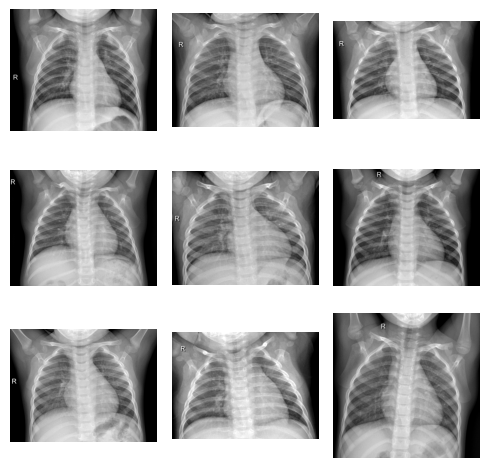

In [ ]:
random_images = [Normal[i] for i in range(9)]
print(' Normal Images')
plt.figure(figsize=(5,5))

#random images
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(random_images[i])
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.tight_layout()  

Pneumonia Images


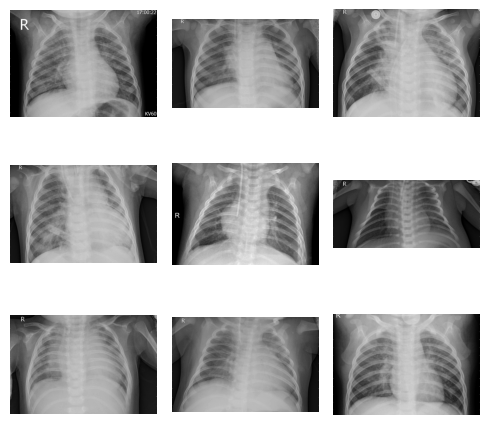

In [ ]:
random_images = [Pneumonia[i] for i in range(9)]
print('Pneumonia Images')
plt.figure(figsize=(5,5))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(random_images[i])
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.tight_layout()  

In [ ]:
print("Number of images in Normal is {}".format(len(Normal)))
print("Number of images in Pneumonia is {}".format(len(Pneumonia)))

Number of images in Normal is 1583
Number of images in Pneumonia is 4273


In [ ]:
COUNT_NORMAL =len(Normal)
COUNT_PNEUMONIA = len(Pneumonia)

In [18]:
from pathlib import Path
data_dir = Path('/content/chest_xray')

train_dir = data_dir / 'train'
val_dir = data_dir / 'val'
test_dir = data_dir / 'test'

In [19]:
import os
from shutil import copyfile
os.makedirs('images/NORMAL', exist_ok=True)
os.makedirs('images/PNEUMONIA', exist_ok=True)

base_path = '/content/chest_xray'

for path in ['/train', '/test', '/val']:
    for dirname, _, filenames in os.walk(base_path + path):
        for i, file in enumerate(filenames):
            img_class = dirname.split('/')[4]
            copyfile(os.path.join(dirname, file), 'images/' + img_class + '/' + file)

In [20]:
import numpy as np
from sklearn.model_selection import train_test_split

os.makedirs('train/NORMAL', exist_ok=True)
os.makedirs('train/PNEUMONIA', exist_ok=True)
os.makedirs('test/NORMAL', exist_ok=True)
os.makedirs('test/PNEUMONIA', exist_ok=True)
os.makedirs('val/NORMAL', exist_ok=True)
os.makedirs('val/PNEUMONIA', exist_ok=True)
os.makedirs('train1/NORMAL', exist_ok=True)
os.makedirs('train1/PNEUMONIA', exist_ok=True)

# Split NORMAL
train, test = train_test_split(os.listdir('images/NORMAL'), 
                               test_size=0.2, 
                               random_state=42)
for img in train:
    copyfile(os.path.join('images/NORMAL/', img), 
             os.path.join('train/NORMAL/', img))
for img in test:
    copyfile(os.path.join('images/NORMAL/', img), 
             os.path.join('test/NORMAL/', img))

In [ ]:
print(len(os.listdir('train/NORMAL/')),len(os.listdir('val/NORMAL/')),len(os.listdir('test/NORMAL/')))

1266 0 317


In [21]:
# train -  validation

train, val = train_test_split(os.listdir('train/NORMAL/'), 
                               test_size=0.25, 
                               random_state=42)
for img in train:
    copyfile(os.path.join('train/NORMAL/', img), 
             os.path.join('train1/NORMAL/', img))
for img in val:
    copyfile(os.path.join('train/NORMAL/', img), 
             os.path.join('val/NORMAL/', img))


In [ ]:
print(len(os.listdir('train1/NORMAL/')),len(os.listdir('val/NORMAL/')),len(os.listdir('test/NORMAL/')))

949 317 317


In [22]:
# Split PNEUMONIA
train, test = train_test_split(os.listdir('images/PNEUMONIA'), 
                               test_size=0.2, 
                               random_state=42)
for img in train:
    copyfile(os.path.join('images/PNEUMONIA/', img), 
             os.path.join('train/PNEUMONIA/', img))
for img in test:
    copyfile(os.path.join('images/PNEUMONIA/', img), 
             os.path.join('test/PNEUMONIA/', img))

In [ ]:
print(len(os.listdir('train/PNEUMONIA/')),len(os.listdir('val/PNEUMONIA/')),len(os.listdir('test/PNEUMONIA/')))

3418 0 855


In [23]:
train, val = train_test_split(os.listdir('train/PNEUMONIA/'), 
                               test_size=0.25, 
                               random_state=42)
for img in train:
    copyfile(os.path.join('train/PNEUMONIA/', img), 
             os.path.join('train1/PNEUMONIA/', img))
for img in val:
    copyfile(os.path.join('train/PNEUMONIA/', img), 
             os.path.join('val/PNEUMONIA/', img))    

In [ ]:
print(len(os.listdir('train1/PNEUMONIA/')),len(os.listdir('val/PNEUMONIA/')),len(os.listdir('test/PNEUMONIA/')))

2563 855 855


# Augmentation 

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# Define the augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=30,
    horizontal_flip=True,
    zoom_range=0.2
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_path = '/content/train1'
val_path = '/content/val'
test_path ='/content/test' 

In [ ]:
batch_size = 32
train_augmented_data = train_datagen.flow_from_directory(train_path, batch_size=batch_size,target_size=(128, 128), class_mode='binary')
val_augmented_data = val_datagen.flow_from_directory(val_path, batch_size=batch_size,target_size=(128, 128), class_mode='binary')
test_augmented_data = test_datagen.flow_from_directory(test_path, batch_size=batch_size,target_size=(128, 128), class_mode='binary')

Found 3512 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.


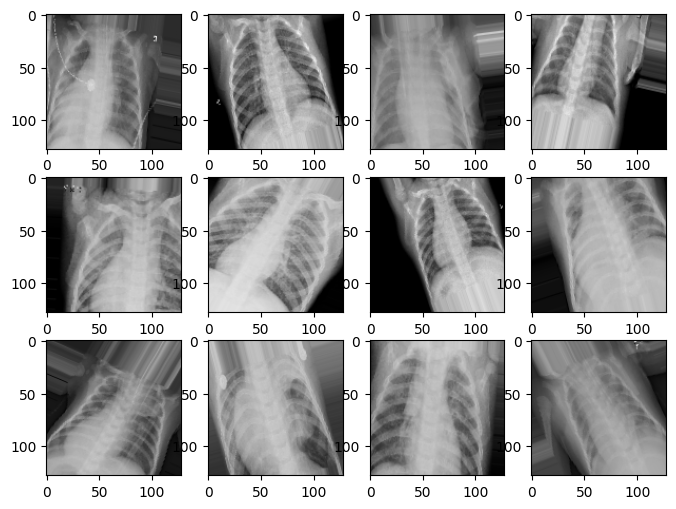

In [ ]:
augmented_images, _ = next(train_augmented_data)
fig, axs = plt.subplots(3, 4, figsize=(8, 6))
axs = axs.ravel()
for i in range(12):
    axs[i].imshow(augmented_images[i])
plt.show()

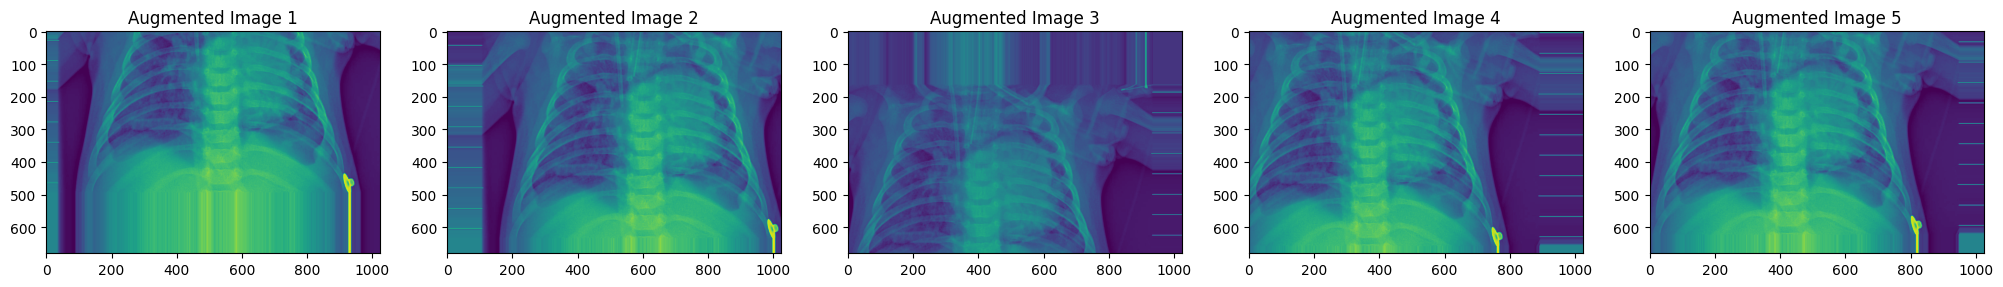

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf

##for each argument comment other arguments 
train_datagen = ImageDataGenerator(
    # rescale=1.0/255,
    # shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    # rotation_range=30,
    # horizontal_flip=True,
    # zoom_range=0.2
)

img_path = '/content/test/PNEUMONIA/person100_bacteria_477.jpeg'
img = plt.imread(img_path)
x = tf.keras.utils.img_to_array(img)  #  shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # (1, 3, 150, 150)

img_generator = train_datagen.flow(
   x,
    batch_size=1,
    seed=42
)

fig, axs = plt.subplots(1, 5, figsize=(25, 5))
for i in range(5):
    img_augmented = next(img_generator).squeeze()
    axs[i].imshow(img_augmented)
    axs[i].set_title(f"Augmented Image {i+1}")
plt.show()


# Model

In [5]:
!pip install efficientnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 4.5 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB3, EfficientNetB4
import efficientnet.keras as efn
import numpy as np

base_model = efn.EfficientNetB2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

31936256/31936256 [==============================] - 2s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 stem_bn (BatchNormalization)   (None, 64, 64, 32)   128         ['stem_conv[0][0]']              
                                                                                                  
 stem_activation (Activation)   (None, 64, 64, 32)   0           ['stem_bn[0][0]']            

In [ ]:
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.metrics import Recall, Precision
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping


opt = Adam(learning_rate = 0.001)
model.compile(optimizer=opt,
              loss='binary_crossentropy', 
              metrics=['accuracy', Recall(), Precision()])

In [ ]:
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return 0.001 * tf.math.exp(0.1 * (10 - epoch))

# LearningRateScheduler callback 
lr_callback = LearningRateScheduler(lr_scheduler)

#  ModelCheckpoint callback  to save the best model weights
checkpoint_callback = ModelCheckpoint(filepath='best_model.h5', 
                                      monitor='val_loss', 
                                      save_best_only=True, 
                                      mode='min')

#  EarlyStopping callback  to stop training if validation loss does not improve for 10 epochs
earlystop_callback = EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
# model_history = model.fit(train_augmented_data,
#                             validation_data=val_augmented_data,
#                             batch_size=128, 
#                             steps_per_epoch=train_augmented_data.n/128,   
#                             validation_steps=val_augmented_data.n/128,        
#                             epochs=25,
#                             verbose=1,
#                             class_weight=class_weight,
#                             callbacks=[lr_callback, checkpoint_callback, earlystop_callback])

# Class weights

In [11]:
COUNT_NORMAL =len(Normal)
COUNT_PNEUMONIA = len(Pneumonia)

In [12]:
print("Number of images in Normal is {}".format(len(Normal)))
print("Number of images in Pneumonia is {}".format(len(Pneumonia)))

Number of images in Normal is 1583
Number of images in Pneumonia is 4273


In [13]:
weight_0 = (COUNT_NORMAL+COUNT_PNEUMONIA) / (COUNT_NORMAL * 2) 
weight_1 = (COUNT_NORMAL+COUNT_PNEUMONIA) / (COUNT_PNEUMONIA * 2) 

In [14]:
weight_0

1.8496525584333543

In [15]:
weight_1

0.6852328574771823

In [16]:
class_weight = {0: 1.8496, 1: 0.6852}


# Second Method

 **In the first method, we didn't reach the accuracy of the paper.
In the first method, we separate the validation set manually, but in the second method, we separate it with validation_split in ImageDataGenerator.**

In [6]:
import efficientnet.keras as efn
from tensorflow.keras.callbacks import Callback
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import Recall, Precision

# Callbacks
mc = ModelCheckpoint('model.hdf5', 
                     save_best_only=True, 
                     verbose=0, 
                     monitor='val_loss', 
                     mode='min')

#  Reduce learning rate (optional)-doesnt mention in paper
# rlr = ReduceLROnPlateau(monitor='val_loss', 
#                         factor=0.3, 
#                         patience=3, 
#                         min_lr=0.000001, 
#                         verbose=1)

def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.1

from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
# LearningRateScheduler callback 
lr_callback = LearningRateScheduler(lr_scheduler)

#  EarlyStopping callback 
earlystop_callback = EarlyStopping(monitor='val_loss', patience=10)



# Model
#  EfficientNet weights
model = efn.EfficientNetB2(weights = 'imagenet', 
                           include_top = False, 
                           input_shape = (128, 128, 3))

# Output layer
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)


# Compile 
model = Model(inputs=model.input, outputs=predictions)

opt = Adam(learning_rate = 0.001)

model.compile(optimizer= opt,
              loss='binary_crossentropy', 
              metrics=['accuracy', Recall(), Precision()])

31936256/31936256 [==============================] - 0s 0us/step


In [24]:
SIZE = 128
BATCH = 128

# image augmentations
image_gen = ImageDataGenerator(
                                validation_split=0.25,

    rescale=1.0/255,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=30,
    horizontal_flip=True,
    zoom_range=0.2)


# flow_from_directory generators
train_generator = image_gen\
    .flow_from_directory('train',
                        target_size=(SIZE, SIZE),
                        class_mode="binary",
                        batch_size=BATCH,
                        subset='training')

validation_generator = image_gen\
    .flow_from_directory('train',
                        target_size=(SIZE, SIZE),
                        class_mode="binary",
                        batch_size=BATCH,
                        subset='validation')

Found 3514 images belonging to 2 classes.
Found 1170 images belonging to 2 classes.


In [25]:
model_history = model.fit(train_generator,
                            validation_data=validation_generator,
                            steps_per_epoch=train_generator.n/BATCH,
                            validation_steps=validation_generator.n/BATCH,
                            epochs=25,
                            verbose=1,
                            class_weight=class_weight,
                            callbacks=[mc, earlystop_callback , lr_callback])

Epoch 1/25
27/27 [==============================] - 93s 3s/step - loss: 0.3340 - accuracy: 0.8657 - recall: 0.8756 - precision: 0.9362 - val_loss: 0.7495 - val_accuracy: 0.8453 - val_recall: 0.9649 - val_precision: 0.8451 - lr: 0.0010
Epoch 2/25
27/27 [==============================] - 68s 2s/step - loss: 0.1728 - accuracy: 0.9334 - recall: 0.9286 - precision: 0.9790 - val_loss: 1.1171 - val_accuracy: 0.7829 - val_recall: 0.9977 - val_precision: 0.7717 - lr: 0.0010
Epoch 3/25
27/27 [==============================] - 67s 2s/step - loss: 0.1680 - accuracy: 0.9402 - recall: 0.9388 - precision: 0.9785 - val_loss: 0.9520 - val_accuracy: 0.8034 - val_recall: 0.9883 - val_precision: 0.7932 - lr: 0.0010
Epoch 4/25
27/27 [==============================] - 68s 2s/step - loss: 0.1427 - accuracy: 0.9474 - recall: 0.9481 - precision: 0.9791 - val_loss: 1.7195 - val_accuracy: 0.7556 - val_recall: 1.0000 - val_precision: 0.7491 - lr: 0.0010
Epoch 5/25
27/27 [==============================] - 67s 2s/s

In [26]:
test_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=5,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1)

test_generator = test_datagen.flow_from_directory(
    directory="test",
    target_size=(SIZE, SIZE),
    class_mode="binary",
    shuffle=False,
    batch_size=BATCH
)

preds = model.predict_generator(generator=test_generator) # predictions
labels = 1*(preds > 0.5) 

Found 1172 images belonging to 2 classes.


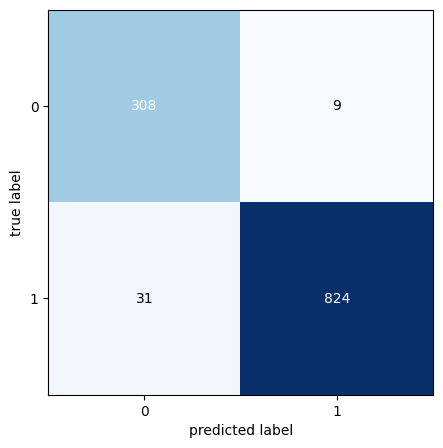

In [27]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
CM = confusion_matrix(test_generator.classes, labels)
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

<Figure size 640x480 with 0 Axes>

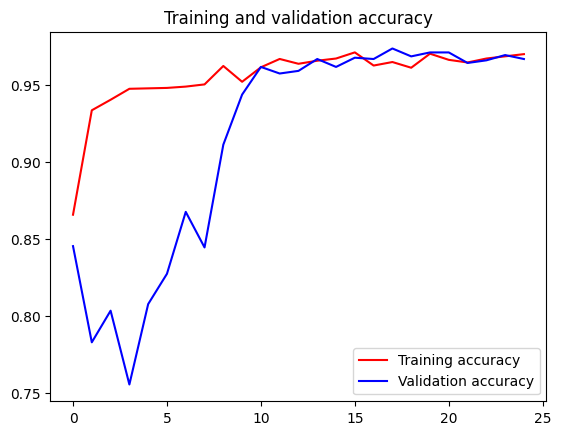

<Figure size 640x480 with 0 Axes>

In [28]:
# Plot 
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

<Figure size 640x480 with 0 Axes>

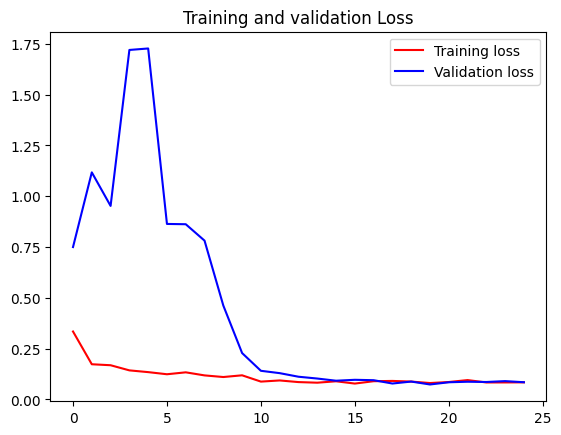

<Figure size 640x480 with 0 Axes>

In [29]:
acc = model_history.history['loss']
val_acc = model_history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training loss')
plt.plot(epochs, val_acc, 'b', label='Validation loss')
plt.title('Training and validation Loss')
plt.legend()
plt.figure()

In [30]:
from sklearn.metrics import classification_report
print(classification_report(test_generator.classes, labels))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       317
           1       0.99      0.96      0.98       855

    accuracy                           0.97      1172
   macro avg       0.95      0.97      0.96      1172
weighted avg       0.97      0.97      0.97      1172



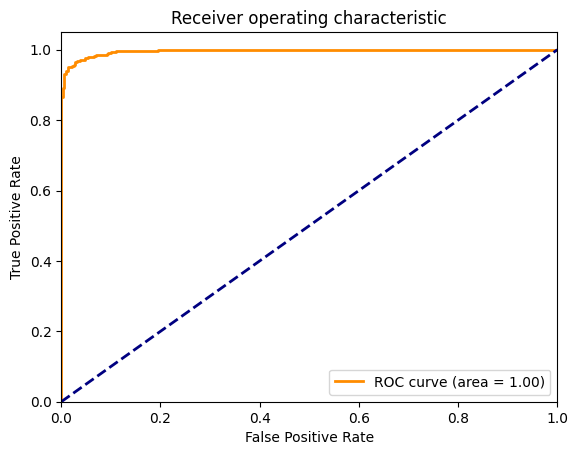

In [31]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(test_generator.classes, preds)

roc_auc = auc(fpr, tpr)

# plot  ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


10/10 [==============================] - 16s 2s/step


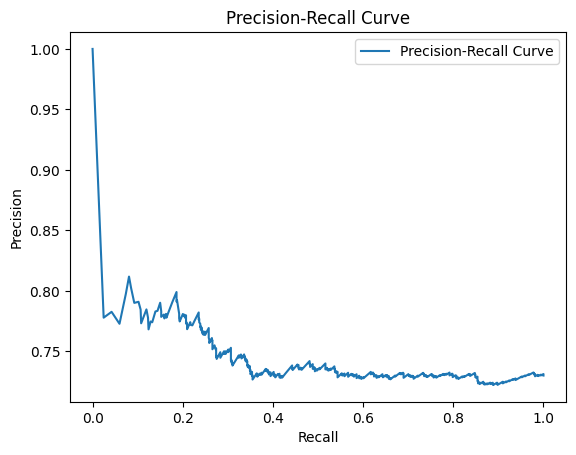

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

y_pred_prob = model.predict(validation_generator)
y_true = validation_generator.classes

precision, recall, thresholds = precision_recall_curve(y_true, y_pred_prob)

# Plot the precision-recall curve
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()